## Gait Project

In [1]:
# install if needed
!pip install ezc3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.5 MB/s eta 0:00:00


In [2]:
import ezc3d
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load walking trials
c3d1 = '/content/drive/MyDrive/Colab Notebooks/Sports/S1C1T1.c3d'
c3d2 = '/content/drive/MyDrive/Colab Notebooks/Sports/S1C1T2.c3d'
c3d3 = '/content/drive/MyDrive/Colab Notebooks/Sports/S1C1T3.c3d'
c3d4 = '/content/drive/MyDrive/Colab Notebooks/Sports/S1C1T4.c3d'
c3d5 = '/content/drive/MyDrive/Colab Notebooks/Sports/S1C1T5.c3d'
c3d_files = [c3d1, c3d2, c3d3, c3d4, c3d5]

In [5]:
# Dictionary to store the C3D objects to access as c3d_objects['S1C1T1.c3d']
c3d_objects = {}

for file_path in c3d_files:
    # Read the c3d file
    try:
        c = ezc3d.c3d(file_path)
        print(f"Successfully read: {file_path}")
        # Store the C3D object in the dictionary using the file name as key
        file_name = file_path.split('/')[-1]
        c3d_objects[file_name] = c
    except Exception as e:
        print(f"Error reading C3D file {file_path}: {e}")
        # Store None if reading fails
        file_name = file_path.split('/')[-1]
        c3d_objects[file_name] = None

Successfully read: /content/drive/MyDrive/Colab Notebooks/Sports/S1C1T1.c3d
Successfully read: /content/drive/MyDrive/Colab Notebooks/Sports/S1C1T2.c3d
Successfully read: /content/drive/MyDrive/Colab Notebooks/Sports/S1C1T3.c3d
Successfully read: /content/drive/MyDrive/Colab Notebooks/Sports/S1C1T4.c3d
Successfully read: /content/drive/MyDrive/Colab Notebooks/Sports/S1C1T5.c3d


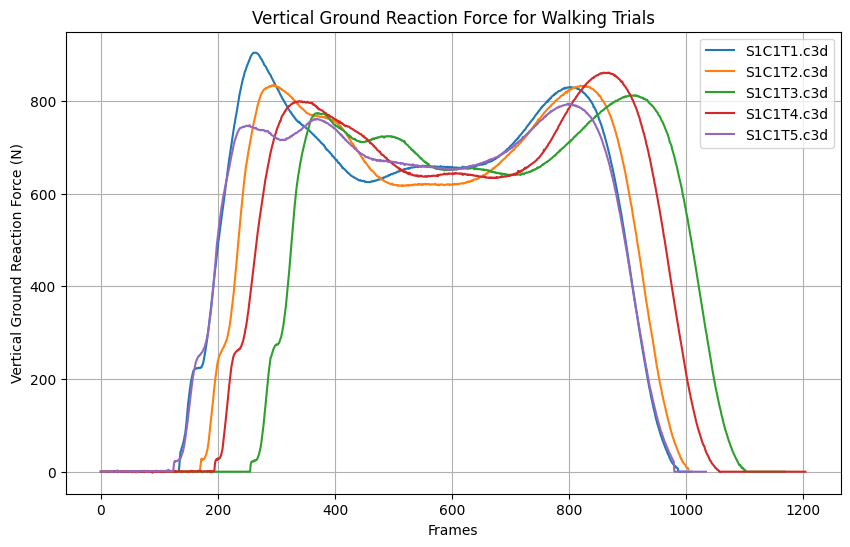

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

if c3d_objects:
    for file_name, c in c3d_objects.items():
        if c is not None:
            try:
                analog_labels = c['parameters']['ANALOG']['LABELS']['value']
                analog_data = c['data']['analogs']

                try:
                    Fz1_index = [i for i, label in enumerate(analog_labels) if label == "Force.Fz1"][0]
                except IndexError:
                    print(f"Warning: 'Force.Fz1' not found in analog labels for {file_name}. Skipping.")
                    continue

                if analog_data.shape[0] == 1 and analog_data.shape[1] == len(analog_labels):
                     vertical_force = analog_data[0, Fz1_index, :]
                elif analog_data.shape[0] == len(analog_labels) and analog_data.shape[2] == 1:
                     vertical_force = analog_data[Fz1_index, :, 0]
                elif analog_data.shape[0] == len(analog_labels) and analog_data.shape[1] == 1:
                     vertical_force = analog_data[Fz1_index, 0, :]
                else:
                    print(f"Warning: Unexpected analog data shape for {file_name}: {analog_data.shape}. Skipping.")
                    continue

                x = np.arange(vertical_force.shape[0])

                ax.plot(x, -vertical_force, label=file_name)

            except KeyError as e:
                print(f"Error accessing data for {file_name}: Missing key {e}.")
            except Exception as e:
                print(f"An unexpected error occurred for {file_name}: {e}")
        else:
            print(f"Skipping {file_name} as C3D object is None.")

    ax.set_xlabel("Frames")
    ax.set_ylabel("Vertical Ground Reaction Force (N)")
    ax.set_title("Vertical Ground Reaction Force for Walking Trials")
    ax.legend()
    plt.grid(True)
    plt.savefig("walking_trials_vGRF.png") # Added savefig
    plt.show()

else:
    print("c3d_objects dictionary is empty or None. Cannot plot data.")

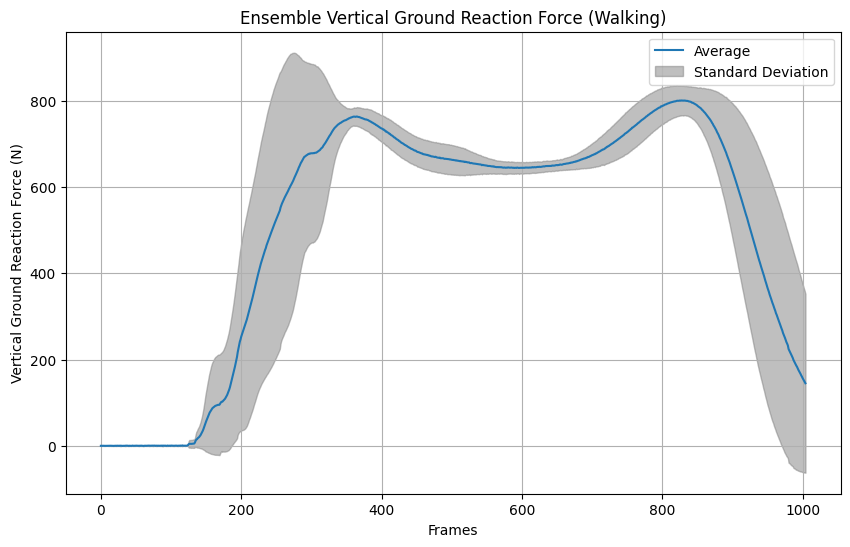

In [7]:
# Collect all vertical force data into a list
all_vertical_forces = []
if c3d_objects:
    for file_name, c in c3d_objects.items():
        if c is not None:
            try:
                analog_labels = c['parameters']['ANALOG']['LABELS']['value']
                analog_data = c['data']['analogs']

                try:
                    Fz1_index = [i for i, label in enumerate(analog_labels) if label == "Force.Fz1"][0]
                except IndexError:
                    print(f"Warning: 'Force.Fz1' not found in analog labels for {file_name}. Skipping.")
                    continue

                # Extract the Fz1 data based on the observed shapes
                if analog_data.shape[0] == 1 and analog_data.shape[1] == len(analog_labels):
                     vertical_force = analog_data[0, Fz1_index, :]
                elif analog_data.shape[0] == len(analog_labels) and analog_data.shape[2] == 1:
                     vertical_force = analog_data[Fz1_index, :, 0]
                elif analog_data.shape[0] == len(analog_labels) and analog_data.shape[1] == 1:
                     vertical_force = analog_data[Fz1_index, 0, :]
                else:
                    print(f"Warning: Unexpected analog data shape for {file_name}: {analog_data.shape}. Skipping.")
                    continue

                # Append the force data (negated for upward force) to the list
                all_vertical_forces.append(-vertical_force)

            except KeyError as e:
                print(f"Error accessing data for {file_name}: Missing key {e}.")
            except Exception as e:
                print(f"An unexpected error occurred for {file_name}: {e}")

# Ensure all trials have the same number of frames
if all_vertical_forces:
    # Find the minimum length among all trials
    min_frames = min(force.shape[0] for force in all_vertical_forces)

    # Truncate all trials to the minimum length
    all_vertical_forces_truncated = [force[:min_frames] for force in all_vertical_forces]

    # Convert the list of arrays into a single NumPy array for easier calculation
    all_vertical_forces_array = np.array(all_vertical_forces_truncated)

    # Calculate the mean and standard deviation across trials for each frame
    mean_force = np.mean(all_vertical_forces_array, axis=0)
    std_force = np.std(all_vertical_forces_array, axis=0)

    # Create the ensemble plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    x = np.arange(min_frames)

    # Plot the average curve
    ax.plot(x, mean_force, label='Average')

    # Plot the shaded area for standard deviation
    ax.fill_between(x, mean_force - std_force, mean_force + std_force, color='grey', alpha=0.5, label='Standard Deviation')

    ax.set_xlabel("Frames")
    ax.set_ylabel("Vertical Ground Reaction Force (N)")
    ax.set_title("Ensemble Vertical Ground Reaction Force (Walking)")
    ax.legend()
    plt.grid(True)
    plt.show()
else:
    print("No vertical force data available to create an ensemble curve.")

In [8]:
# Load Running Trials
c3d6 = '/content/drive/MyDrive/Colab Notebooks/Sports/S1C2T1.c3d'
c3d7 = '/content/drive/MyDrive/Colab Notebooks/Sports/S1C2T2.c3d'
c3d8 = '/content/drive/MyDrive/Colab Notebooks/Sports/S1C2T3.c3d'
c3d9 = '/content/drive/MyDrive/Colab Notebooks/Sports/S1C2T4.c3d'
c3d10 = '/content/drive/MyDrive/Colab Notebooks/Sports/S1C2T5.c3d'

# Create a list of the new C3D file paths
c3d_files_new = [c3d6, c3d7, c3d8, c3d9, c3d10]

# Dictionary to store the new C3D objects
c3d_objects_new = {}

# Iterate through the new C3D files and load them
for file_path in c3d_files_new:
    try:
        c_new = ezc3d.c3d(file_path)
        print(f"Successfully read: {file_path}")
        # Store the C3D object in the dictionary using the file name as key
        file_name = file_path.split('/')[-1]
        c3d_objects_new[file_name] = c_new
    except Exception as e:
        print(f"Error reading C3D file {file_path}: {e}")
        # Store None if reading fails
        file_name = file_path.split('/')[-1]
        c3d_objects_new[file_name] = None

Successfully read: /content/drive/MyDrive/Colab Notebooks/Sports/S1C2T1.c3d
Successfully read: /content/drive/MyDrive/Colab Notebooks/Sports/S1C2T2.c3d
Successfully read: /content/drive/MyDrive/Colab Notebooks/Sports/S1C2T3.c3d
Successfully read: /content/drive/MyDrive/Colab Notebooks/Sports/S1C2T4.c3d
Successfully read: /content/drive/MyDrive/Colab Notebooks/Sports/S1C2T5.c3d


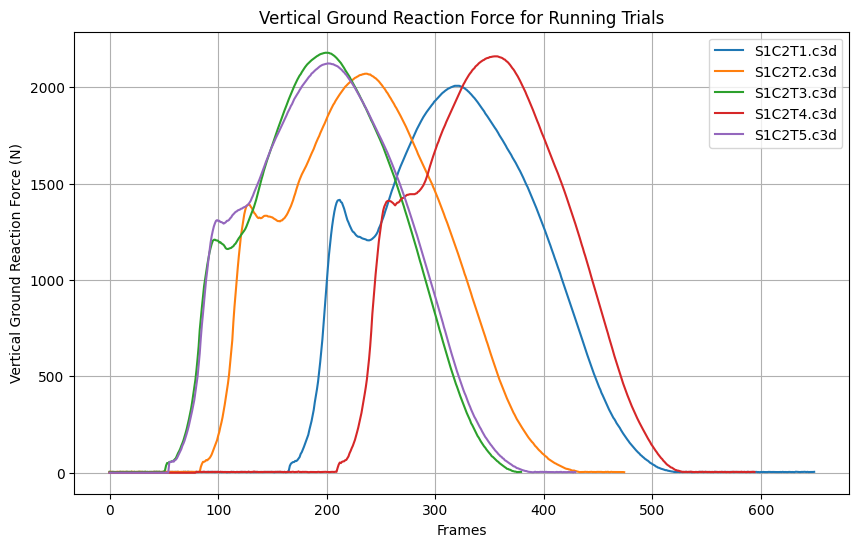

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

if c3d_objects_new:
    for file_name, c_new in c3d_objects_new.items():
        if c_new is not None:
            try:
                analog_labels_new = c_new['parameters']['ANALOG']['LABELS']['value']
                analog_data_new = c_new['data']['analogs']

                try:
                    Fz1_index_new = [i for i, label in enumerate(analog_labels_new) if label == "Force.Fz1"][0]
                except IndexError:
                    print(f"Warning: 'Force.Fz1' not found in analog labels for {file_name}. Skipping.")
                    continue

                # Extract the Fz1 data based on the observed shapes
                if analog_data_new.shape[0] == 1 and analog_data_new.shape[1] == len(analog_labels_new):
                     vertical_force_new = analog_data_new[0, Fz1_index_new, :]
                elif analog_data_new.shape[0] == len(analog_labels_new) and analog_data_new.shape[2] == 1:
                     vertical_force_new = analog_data_new[Fz1_index_new, :, 0]
                elif analog_data_new.shape[0] == len(analog_labels_new) and analog_data_new.shape[1] == 1:
                     vertical_force_new = analog_data_new[Fz1_index_new, 0, :]
                else:
                    print(f"Warning: Unexpected analog data shape for {file_name}: {analog_data_new.shape}. Skipping.")
                    continue


                x_new = np.arange(vertical_force_new.shape[0])

                ax.plot(x_new, -vertical_force_new, label=file_name)

            except KeyError as e:
                print(f"Error accessing data for {file_name}: Missing key {e}.")
            except Exception as e:
                print(f"An unexpected error occurred for {file_name}: {e}")
        else:
            print(f"Skipping {file_name} as C3D object is None.")

    ax.set_xlabel("Frames")
    ax.set_ylabel("Vertical Ground Reaction Force (N)")
    ax.set_title("Vertical Ground Reaction Force for Running Trials")
    ax.legend()
    plt.grid(True)
    plt.savefig("running_trials_vGRF.png")
    plt.show()

else:
    print("c3d_objects_new dictionary is empty or None. Cannot plot data.")

# Can't fo ensemble due to cutting off frames

# Apply Butterworth

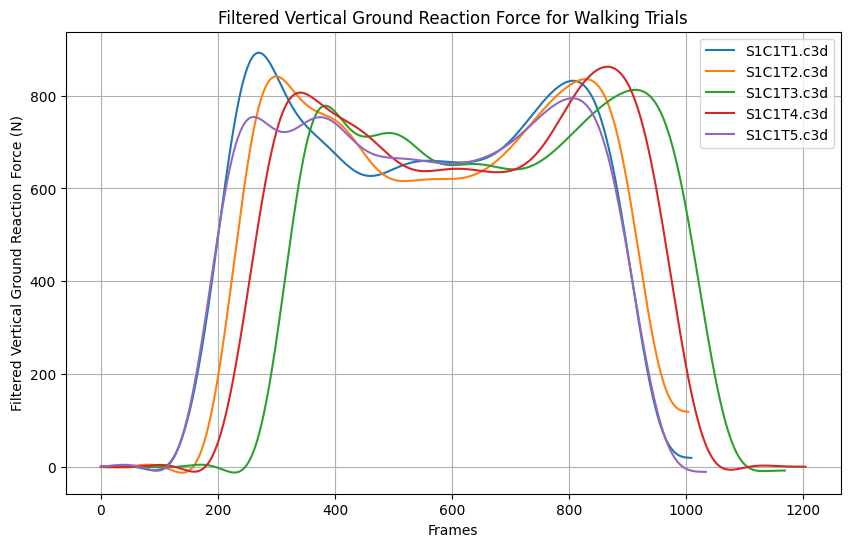

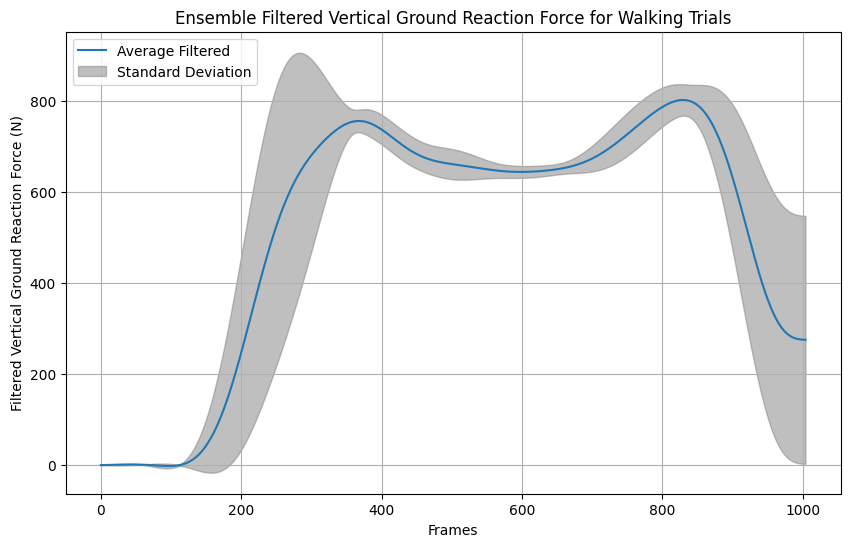

In [10]:
# Obtain sampling frequency from one of the loaded C3D objects
if c3d_objects and list(c3d_objects.values())[0] is not None:
    fs = list(c3d_objects.values())[0]['header']['analogs']['frame_rate']
    cutoff = 10  # Cutoff frequency in Hz
    order = 4    # Filter order

    # Design the Butterworth filter
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)

    # Dictionary to store the filtered force data
    filtered_fz_data_walking = {}
    all_vertical_forces_walking = []

    # Apply the filter to each walking trial's force data
    if c3d_objects:
        for file_name, c in c3d_objects.items():
            if c is not None:
                try:
                    analog_labels = c['parameters']['ANALOG']['LABELS']['value']
                    analog_data = c['data']['analogs']

                    try:
                        Fz1_index = [i for i, label in enumerate(analog_labels) if label == "Force.Fz1"][0]
                    except IndexError:
                        print(f"Warning: 'Force.Fz1' not found in analog labels for {file_name}. Skipping.")
                        continue

                    # Extract the Fz1 data based on the observed shapes
                    if analog_data.shape[0] == 1 and analog_data.shape[1] == len(analog_labels):
                         vertical_force = analog_data[0, Fz1_index, :]
                    elif analog_data.shape[0] == len(analog_labels) and analog_data.shape[2] == 1:
                         vertical_force = analog_data[Fz1_index, :, 0]
                    elif analog_data.shape[0] == len(analog_labels) and analog_data.shape[1] == 1:
                         vertical_force = analog_data[Fz1_index, 0, :]
                    else:
                        print(f"Warning: Unexpected analog data shape for {file_name}: {analog_data.shape}. Skipping.")
                        continue

                    # Append the force data (negated for upward force) to the list for ensemble calculation
                    all_vertical_forces_walking.append(-vertical_force)

                    # Apply the filter
                    filtered_data = filtfilt(b, a, -vertical_force) # Apply filter to negated force
                    filtered_fz_data_walking[file_name] = filtered_data

                except KeyError as e:
                    print(f"Error accessing data for {file_name}: Missing key {e}.")
                except Exception as e:
                    print(f"An unexpected error occurred for {file_name}: {e}")
            else:
                print(f"Skipping {file_name} as C3D object is None.")

    # Plot individual filtered curves
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    if filtered_fz_data_walking:
        for file_name, filtered_data in filtered_fz_data_walking.items():
            if filtered_data is not None:
                x = np.arange(filtered_data.shape[0])
                ax.plot(x, filtered_data, label=file_name)
            else:
                print(f"Skipping plotting for {file_name} as filtered data is None.")

        ax.set_xlabel("Frames")
        ax.set_ylabel("Filtered Vertical Ground Reaction Force (N)")
        ax.set_title("Filtered Vertical Ground Reaction Force for Walking Trials")
        ax.legend()
        plt.grid(True)
        plt.show()
    else:
        print("No filtered vertical force data available to plot individual curves for walking trials.")

    # Generate and plot ensemble filtered curve
    if all_vertical_forces_walking:
        min_frames_walking = min(force.shape[0] for force in all_vertical_forces_walking)
        all_vertical_forces_truncated_walking = [force[:min_frames_walking] for force in all_vertical_forces_walking]
        all_vertical_forces_array_walking = np.array(all_vertical_forces_truncated_walking)

        # Apply filter to the truncated array for ensemble
        # Need to apply filter along the frame axis (axis=1) after transposing
        # Transpose to (frames, trials)
        all_vertical_forces_array_walking_T = all_vertical_forces_array_walking.T

        # Apply filter to each column (trial)
        filtered_ensemble_data_T = filtfilt(b, a, all_vertical_forces_array_walking_T, axis=0)

        # Transpose back to (trials, frames)
        filtered_ensemble_data = filtered_ensemble_data_T.T


        mean_force_filtered_walking = np.mean(filtered_ensemble_data, axis=0)
        std_force_filtered_walking = np.std(filtered_ensemble_data, axis=0)

        fig, ax = plt.subplots(1, 1, figsize=(10, 6))

        x_filtered_walking = np.arange(min_frames_walking)

        ax.plot(x_filtered_walking, mean_force_filtered_walking, label='Average Filtered')
        ax.fill_between(x_filtered_walking, mean_force_filtered_walking - std_force_filtered_walking, mean_force_filtered_walking + std_force_filtered_walking, color='grey', alpha=0.5, label='Standard Deviation')

        ax.set_xlabel("Frames")
        ax.set_ylabel("Filtered Vertical Ground Reaction Force (N)")
        ax.set_title("Ensemble Filtered Vertical Ground Reaction Force for Walking Trials")
        ax.legend()
        plt.grid(True)
        plt.show()
    else:
        print("No vertical force data available from walking trials to create an ensemble filtered curve.")


else:
    print("No C3D objects loaded for walking trials. Cannot apply filter or plot.")

In [11]:
target_frames = 101
normalized_walking_forces = []

if c3d_objects:
    for file_name, c in c3d_objects.items():
        if c is not None:
            try:
                analog_labels = c['parameters']['ANALOG']['LABELS']['value']
                analog_data = c['data']['analogs']

                try:
                    Fz1_index = [i for i, label in enumerate(analog_labels) if label == "Force.Fz1"][0]
                except IndexError:
                    print(f"Warning: 'Force.Fz1' not found in analog labels for {file_name}. Skipping time normalization for this file.")
                    continue

                # Extract the Fz1 data based on the observed shapes
                if analog_data.shape[0] == 1 and analog_data.shape[1] == len(analog_labels):
                     vertical_force = analog_data[0, Fz1_index, :]
                elif analog_data.shape[0] == len(analog_labels) and analog_data.shape[2] == 1:
                     vertical_force = analog_data[Fz1_index, :, 0]
                elif analog_data.shape[0] == len(analog_labels) and analog_data.shape[1] == 1:
                     vertical_force = analog_data[Fz1_index, 0, :]
                else:
                    print(f"Warning: Unexpected analog data shape for {file_name}: {analog_data.shape}. Skipping time normalization for this file.")
                    continue

                # Negate the vertical force for upward direction
                vertical_force = -vertical_force

                # Create a time vector for the original data
                original_frames = vertical_force.shape[0]
                original_time = np.linspace(0, 1, original_frames) # Normalize time from 0 to 1

                # Create an interpolation function
                interp_func = interp1d(original_time, vertical_force)

                # Create a new time vector for the target number of frames
                new_time = np.linspace(0, 1, target_frames)

                # Interpolate the force data to the new time vector
                normalized_force = interp_func(new_time)

                normalized_walking_forces.append(normalized_force)

            except KeyError as e:
                print(f"Error accessing data for {file_name}: Missing key {e}.")
            except Exception as e:
                print(f"An unexpected error occurred during time normalization for {file_name}: {e}")
        else:
            print(f"Skipping {file_name} as C3D object is None.")

if normalized_walking_forces:
    print(f"Time normalization complete for {len(normalized_walking_forces)} walking trials.")
    # You can now work with the list normalized_walking_forces
else:
    print("No walking trial data available for time normalization.")

Time normalization complete for 5 walking trials.


In [12]:
normalized_running_forces = []

if c3d_objects_new:
    for file_name, c_new in c3d_objects_new.items():
        if c_new is not None:
            try:
                analog_labels_new = c_new['parameters']['ANALOG']['LABELS']['value']
                analog_data_new = c_new['data']['analogs']

                try:
                    Fz1_index_new = [i for i, label in enumerate(analog_labels_new) if label == "Force.Fz1"][0]
                except IndexError:
                    print(f"Warning: 'Force.Fz1' not found in analog labels for {file_name}. Skipping time normalization for this file.")
                    continue

                # Extract the Fz1 data based on the observed shapes
                if analog_data_new.shape[0] == 1 and analog_data_new.shape[1] == len(analog_labels_new):
                     vertical_force_new = analog_data_new[0, Fz1_index_new, :]
                elif analog_data_new.shape[0] == len(analog_labels_new) and analog_data_new.shape[2] == 1:
                     vertical_force_new = analog_data_new[Fz1_index_new, :, 0]
                elif analog_data_new.shape[0] == len(analog_labels_new) and analog_data_new.shape[1] == 1:
                     vertical_force_new = analog_data_new[Fz1_index_new, 0, :]
                else:
                    print(f"Warning: Unexpected analog data shape for {file_name}: {analog_data_new.shape}. Skipping time normalization for this file.")
                    continue

                # Negate the vertical force for upward direction
                vertical_force_new = -vertical_force_new

                # Create a time vector for the original data
                original_frames_new = vertical_force_new.shape[0]
                original_time_new = np.linspace(0, 1, original_frames_new) # Normalize time from 0 to 1

                # Create an interpolation function
                interp_func_new = interp1d(original_time_new, vertical_force_new)

                # Create a new time vector for the target number of frames
                new_time = np.linspace(0, 1, target_frames)

                # Interpolate the force data to the new time vector
                normalized_force_new = interp_func_new(new_time)

                normalized_running_forces.append(normalized_force_new)

            except KeyError as e:
                print(f"Error accessing data for {file_name}: Missing key {e}.")
            except Exception as e:
                print(f"An unexpected error occurred during time normalization for {file_name}: {e}")
        else:
            print(f"Skipping {file_name} as C3D object is None.")

if normalized_running_forces:
    print(f"Time normalization complete for {len(normalized_running_forces)} running trials.")
    # You can now work with the list normalized_running_forces
else:
    print("No running trial data available for time normalization.")

Time normalization complete for 5 running trials.


In [13]:
# Convert the lists of normalized forces into NumPy arrays
normalized_walking_array = np.array(normalized_walking_forces)
normalized_running_array = np.array(normalized_running_forces)

# Calculate the mean and standard deviation for each condition across trials (axis=0)
mean_walking_force = np.mean(normalized_walking_array, axis=0)
std_walking_force = np.std(normalized_walking_array, axis=0)

mean_running_force = np.mean(normalized_running_array, axis=0)
std_running_force = np.std(normalized_running_array, axis=0)

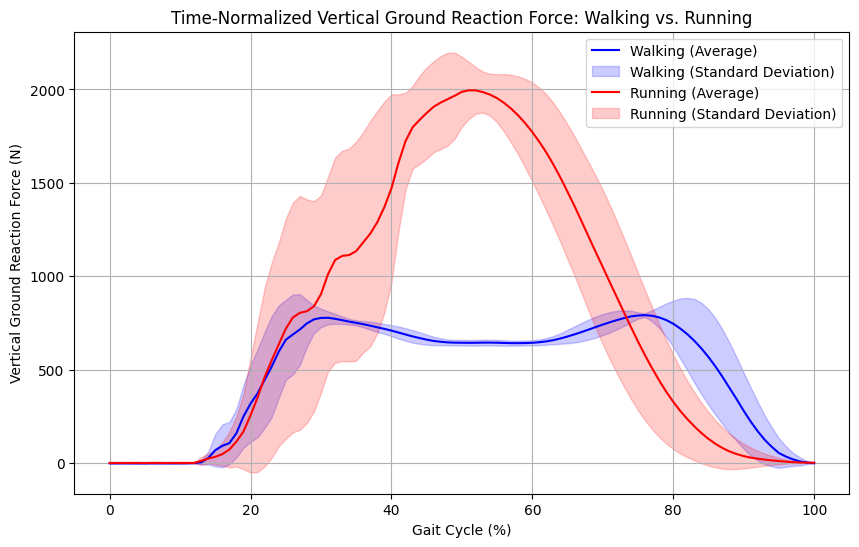

In [14]:
# Create a single plot for combined normalized curves
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(np.linspace(0, 100, target_frames), mean_walking_force, label='Walking (Average)', color='blue')
ax.fill_between(np.linspace(0, 100, target_frames), mean_walking_force - std_walking_force, mean_walking_force + std_walking_force, color='blue', alpha=0.2, label='Walking (Standard Deviation)')
ax.plot(np.linspace(0, 100, target_frames), mean_running_force, label='Running (Average)', color='red')
ax.fill_between(np.linspace(0, 100, target_frames), mean_running_force - std_running_force, mean_running_force + std_running_force, color='red', alpha=0.2, label='Running (Standard Deviation)')

ax.set_xlabel("Gait Cycle (%)")
ax.set_ylabel("Vertical Ground Reaction Force (N)")
ax.set_title("Time-Normalized Vertical Ground Reaction Force: Walking vs. Running")
ax.legend()
plt.grid(True)

# Save the figure before showing it
plt.savefig("standardized_vGRF_trials.png")

plt.show()

Why does this matter?

- We could not have same gait cycle to compare

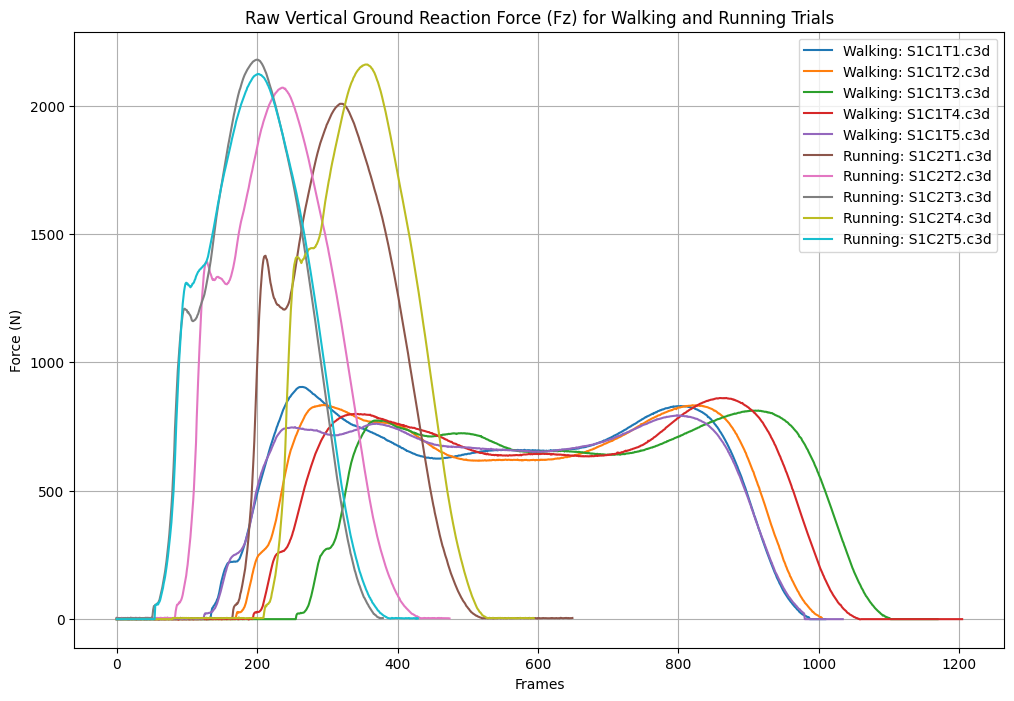

In [15]:
plt.figure(figsize=(12, 8))

# Plot raw Fz data for walking trials (Condition 1)
if c3d_objects:
    for file_name, c in c3d_objects.items():
        if c is not None:
            try:
                analog_labels = c['parameters']['ANALOG']['LABELS']['value']
                analog_data = c['data']['analogs']

                try:
                    # Find the index of the 'Force.Fz1' label
                    Fz1_index = [i for i, label in enumerate(analog_labels) if label == "Force.Fz1"][0]
                except IndexError:
                    print(f"Warning: 'Force.Fz1' not found in analog labels for {file_name}. Skipping.")
                    continue

                # Extract the Fz1 data based on observed shapes
                if analog_data.shape[0] == 1 and analog_data.shape[1] == len(analog_labels):
                     vertical_force = analog_data[0, Fz1_index, :]
                elif analog_data.shape[0] == len(analog_labels) and analog_data.shape[2] == 1:
                     vertical_force = analog_data[Fz1_index, :, 0]
                elif analog_data.shape[0] == len(analog_labels) and analog_data.shape[1] == 1:
                     vertical_force = analog_data[Fz1_index, 0, :]
                else:
                    print(f"Warning: Unexpected analog data shape for {file_name}: {analog_data.shape}. Skipping.")
                    continue

                # Negate the vertical force data to represent upward force
                raw_fz = -vertical_force
                plt.plot(raw_fz, label=f'Walking: {file_name}')

            except KeyError as e:
                print(f"Error accessing data for {file_name}: Missing key {e}.")
            except Exception as e:
                print(f"An unexpected error occurred for {file_name}: {e}")
        else:
            print(f"Skipping {file_name} for walking as C3D object is None.")
else:
    print("No C3D objects loaded for walking trials.")


# Plot raw Fz data for new trials (Condition 2 - Running)
if c3d_objects_new:
    for file_name, c_new in c3d_objects_new.items():
        if c_new is not None:
            try:
                analog_labels_new = c_new['parameters']['ANALOG']['LABELS']['value']
                analog_data_new = c_new['data']['analogs']

                try:
                    # Find the index of the 'Force.Fz1' label
                    Fz1_index_new = [i for i, label in enumerate(analog_labels_new) if label == "Force.Fz1"][0]
                except IndexError:
                    print(f"Warning: 'Force.Fz1' not found in analog labels for {file_name}. Skipping.")
                    continue

                # Extract the Fz1 data based on observed shapes
                if analog_data_new.shape[0] == 1 and analog_data_new.shape[1] == len(analog_labels_new):
                     vertical_force_new = analog_data_new[0, Fz1_index_new, :]
                elif analog_data_new.shape[0] == len(analog_labels_new) and analog_data_new.shape[2] == 1:
                     vertical_force_new = analog_data_new[Fz1_index_new, :, 0]
                elif analog_data_new.shape[0] == len(analog_labels_new) and analog_data_new.shape[1] == 1:
                     vertical_force_new = analog_data_new[Fz1_index_new, 0, :]
                else:
                    print(f"Warning: Unexpected analog data shape for {file_name}: {analog_data_new.shape}. Skipping.")
                    continue

                # Negate the vertical force data to represent upward force
                raw_fz_new = -vertical_force_new
                plt.plot(raw_fz_new, label=f'Running: {file_name}')

            except KeyError as e:
                print(f"Error accessing data for {file_name}: Missing key {e}.")
            except Exception as e:
                print(f"An unexpected error occurred for {file_name}: {e}")
        else:
            print(f"Skipping {file_name} for running as C3D object is None.")
else:
    print("No new C3D objects loaded for running trials.")

plt.title("Raw Vertical Ground Reaction Force (Fz) for Walking and Running Trials")
plt.xlabel("Frames")
plt.ylabel("Force (N)")
plt.legend()
plt.grid(True)

plt.savefig("not_standardized_raw_vGRF_trials.png")

plt.show()

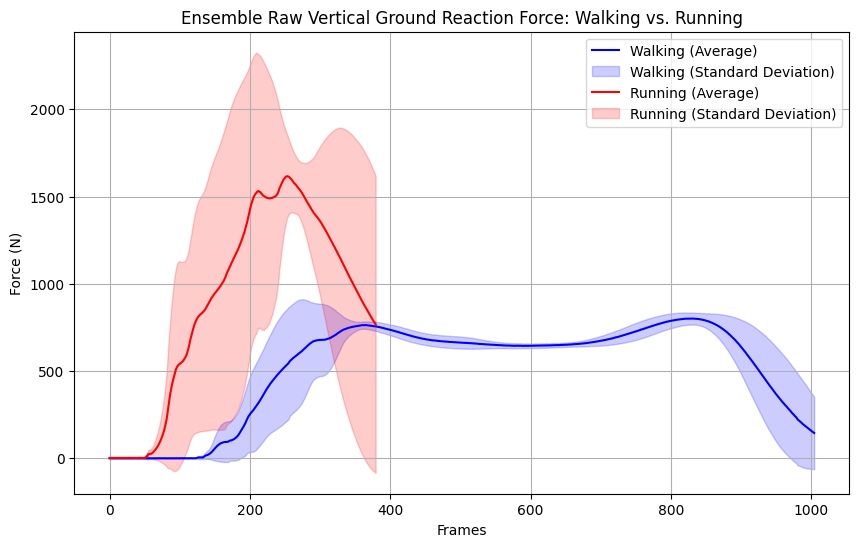

In [16]:
# Collect all raw vertical force data into lists for walking and running
all_raw_walking_forces = []
all_raw_running_forces = []

# Process walking trials
if c3d_objects:
    for file_name, c in c3d_objects.items():
        if c is not None:
            try:
                analog_labels = c['parameters']['ANALOG']['LABELS']['value']
                analog_data = c['data']['analogs']

                try:
                    Fz1_index = [i for i, label in enumerate(analog_labels) if label == "Force.Fz1"][0]
                except IndexError:
                    print(f"Warning: 'Force.Fz1' not found in analog labels for {file_name}. Skipping.")
                    continue

                # Extract the Fz1 data based on observed shapes
                if analog_data.shape[0] == 1 and analog_data.shape[1] == len(analog_labels):
                     vertical_force = analog_data[0, Fz1_index, :]
                elif analog_data.shape[0] == len(analog_labels) and analog_data.shape[2] == 1:
                     vertical_force = analog_data[Fz1_index, :, 0]
                elif analog_data.shape[0] == len(analog_labels) and analog_data.shape[1] == 1:
                     vertical_force = analog_data[Fz1_index, 0, :]
                else:
                    print(f"Warning: Unexpected analog data shape for {file_name}: {analog_data.shape}. Skipping.")
                    continue

                # Negate the vertical force data to represent upward force
                all_raw_walking_forces.append(-vertical_force)

            except KeyError as e:
                print(f"Error accessing data for {file_name}: Missing key {e}.")
            except Exception as e:
                print(f"An unexpected error occurred for {file_name}: {e}")
        else:
            print(f"Skipping {file_name} for walking as C3D object is None.")
else:
    print("No C3D objects loaded for walking trials.")

if c3d_objects_new:
    for file_name, c_new in c3d_objects_new.items():
        if c_new is not None:
            try:
                analog_labels_new = c_new['parameters']['ANALOG']['LABELS']['value']
                analog_data_new = c_new['data']['analogs']

                try:
                    Fz1_index_new = [i for i, label in enumerate(analog_labels_new) if label == "Force.Fz1"][0]
                except IndexError:
                    print(f"Warning: 'Force.Fz1' not found in analog labels for {file_name}. Skipping.")
                    continue

                # Extract the Fz1 data based on observed shapes
                if analog_data_new.shape[0] == 1 and analog_data_new.shape[1] == len(analog_labels_new):
                     vertical_force_new = analog_data_new[0, Fz1_index_new, :]
                elif analog_data_new.shape[0] == len(analog_labels_new) and analog_data_new.shape[2] == 1:
                     vertical_force_new = analog_data_new[Fz1_index_new, :, 0]
                elif analog_data_new.shape[0] == len(analog_labels_new) and analog_data_new.shape[1] == 1:
                     vertical_force_new = analog_data_new[Fz1_index_new, 0, :]
                else:
                    print(f"Warning: Unexpected analog data shape for {file_name}: {analog_data_new.shape}. Skipping.")
                    continue

                # Negate the vertical force data to represent upward force
                all_raw_running_forces.append(-vertical_force_new)

            except KeyError as e:
                print(f"Error accessing data for {file_name}: Missing key {e}.")
            except Exception as e:
                print(f"An unexpected error occurred for {file_name}: {e}")
        else:
            print(f"Skipping {file_name} for running as C3D object is None.")
else:
    print("No new C3D objects loaded for running trials.")

if all_raw_walking_forces:
    min_frames_walking = min(force.shape[0] for force in all_raw_walking_forces)
    all_raw_walking_forces_truncated = [force[:min_frames_walking] for force in all_raw_walking_forces]
    all_raw_walking_array = np.array(all_raw_walking_forces_truncated)
    mean_walking_force = np.mean(all_raw_walking_array, axis=0)
    std_walking_force = np.std(all_raw_walking_array, axis=0)
else:
    mean_walking_force = np.array([])
    std_walking_force = np.array([])
    print("No walking trial data available for ensemble plot.")

if all_raw_running_forces:
    min_frames_running = min(force.shape[0] for force in all_raw_running_forces)
    all_raw_running_forces_truncated = [force[:min_frames_running] for force in all_raw_running_forces]
    all_raw_running_array = np.array(all_raw_running_forces_truncated)
    mean_running_force = np.mean(all_raw_running_array, axis=0)
    std_running_force = np.std(all_raw_running_array, axis=0)
else:
    mean_running_force = np.array([])
    std_running_force = np.array([])
    print("No running trial data available for ensemble plot.")

# Create the ensemble plot
plt.figure(figsize=(10, 6))

if mean_walking_force.size > 0:
    x_walking = np.arange(min_frames_walking)
    plt.plot(x_walking, mean_walking_force, label='Walking (Average)', color='blue')
    plt.fill_between(x_walking, mean_walking_force - std_walking_force, mean_walking_force + std_walking_force, color='blue', alpha=0.2, label='Walking (Standard Deviation)')

if mean_running_force.size > 0:
    x_running = np.arange(min_frames_running)
    plt.plot(x_running, mean_running_force, label='Running (Average)', color='red')
    plt.fill_between(x_running, mean_running_force - std_running_force, mean_running_force + std_running_force, color='red', alpha=0.2, label='Running (Standard Deviation)')

plt.title("Ensemble Raw Vertical Ground Reaction Force: Walking vs. Running")
plt.xlabel("Frames")
plt.ylabel("Force (N)")
plt.legend()
plt.grid(True)

plt.savefig("not_standardized_raw_vGRF.png")

plt.show()